In [24]:
import pandas as pd
import datetime as datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import json
with open('data.json') as x:
    unstructured = json.loads(x.read())

dates = list(unstructured.keys())
datetime = pd.to_datetime(list(unstructured.keys()))

newDict = {}
for x,y in zip(dates, datetime):
    newDict[y] = ' '.join([comment['body'] for comment in unstructured[x]])

    

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score





import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes, outputFile='',
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if outputFile == '':
        pass
    else:
        plt.savefig(outputFile)

In [ ]:
import os
import pandas as pd
files = os.listdir('QF401 Data')
results = {}
for x in files:
    #setting up data from dataframe
    print('predicting index ' + str(x) + '\n\n\n')
    data = pd.read_excel('QF401 Data/' + x)
    data.columns = ['price', 'put call ratio']
    data = data.iloc[1:]
    data = data.sort_index(ascending=True)
    data = data[data['put call ratio'].notnull()]
    
    
    
    #incrementing to get next day price shift
    increment = [0] + data['price'].values.tolist()
    data['priceShift'] = increment[:-1] - data['price'] 
    #creating target variable
    data['target'] = data['priceShift'].apply(lambda x: 0 if x < 0 else 1)
    
    
    #running logistic regression
    for m in ('putcall', 'reddit'):
        if m == 'putcall':
            model = LogisticRegression()
        if m == 'reddit':
            data = data.join(pd.DataFrame.from_dict(newDict, orient='index', columns=['text']), how='inner')
            model = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(learning_rate = 1, n_estimators = 300, algorithm = 'SAMME'))])

        accuracies, rocs, mcc = [], [], [] 
        for i in range(1, 10):
            print('test ' + str(i))
            train,test = train_test_split(data)
            if m == 'reddit':
                model.fit(train['text'], train['target'])
                testInput = test['text']
    
            if m == 'putcall':
                model.fit(train['put call ratio'].values.reshape(-1,1), train['target'])
                testInput = test['put call ratio'].values.reshape(-1, 1)
            
            predictions = model.predict(testInput)
            accuracies += [accuracy_score(test['target'], predictions)]
            rocs += [roc_auc_score(test['target'], predictions)]
            mcc += [matthews_corrcoef(test['target'], predictions)]


            print('accuracy score is ' + str(accuracies[-1]))
            print('roc_auc_score is ' + str(rocs[-1]))
            print('mcc is ' + str(mcc[-1]))
        
        results[x + ' ' + m] = {'accuracy': np.mean(accuracies), 'roc': np.mean(rocs), 'mcc': np.mean(mcc)}
        print('\n\nmean accuracy score is ' + str(np.mean(accuracies)))
        print('mean roc score is ' + str(np.mean(rocs)))
        print('mean mcc score is ' + str(np.mean(mcc)))
        plot_confusion_matrix(confusion_matrix(test['target'], predictions), classes=['price up', 'price down'], outputFile='confusionMatrices/confusionMatrix' + m + x + '.png')

predicting index EEM.xlsx



test 1
accuracy score is 0.507537688442211
roc_auc_score is 0.4978400909435392
mcc is -0.01642832882724579
test 2
accuracy score is 0.5201005025125628
roc_auc_score is 0.5009105394946506
mcc is 0.006119762734284012
test 3
accuracy score is 0.507537688442211
roc_auc_score is 0.5027401065737302
mcc is 0.01843030560814873
test 4
accuracy score is 0.5251256281407035
roc_auc_score is 0.4956743292833647
mcc is -0.024752032034298602
test 5
accuracy score is 0.5213567839195979
roc_auc_score is 0.49589144293283866
mcc is -0.031212575904988285
test 6
accuracy score is 0.5314070351758794
roc_auc_score is 0.49772237025758154
mcc is -0.015715405560093435
test 7
accuracy score is 0.5326633165829145
roc_auc_score is 0.5004948610582414
mcc is 0.0024411923064195725
test 8
accuracy score is 0.5037688442211056
roc_auc_score is 0.48993428535321626
mcc is -0.05047088869079619
test 9
accuracy score is 0.5364321608040201
roc_auc_score is 0.503380371016331
mcc is 0.030280602476892

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


accuracy score is 0.5069637883008357
roc_auc_score is 0.5
mcc is 0.0
test 2


/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


accuracy score is 0.5487465181058496
roc_auc_score is 0.5
mcc is 0.0
test 3



KeyboardInterrupt



In [27]:
model.

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ithm='SAMME', base_estimator=None, learning_rate=1,
          n_estimators=300, random_state=None))])

In [ ]:
confusion_matrix(test['target'], predictions)
accuracy_score(test['target'], predictions)

Confusion matrix, without normalization
[[400   8]
 [380   8]]


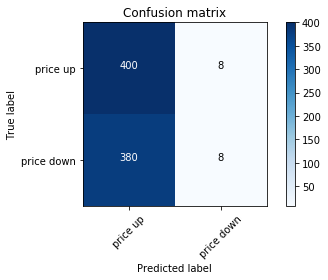

In [84]:
plot_confusion_matrix(confusion_matrix(test['target'], predictions), classes=['price up', 'price down'])

0.5005053567818879

0.0035997036270027484

### predicting from reddit data

In [117]:
len(unstructured)

2078

,price,put call ratio,priceShift,target
2000-11-28,27,12.5,-27,0
2001-01-05,28.25,1,-1.25,0
2001-01-09,28.1875,30,0.0625,1
2001-01-19,29.1406,6.6667,-0.9531,0
2001-02-01,29.61,2.931,-0.4694,0
2001-02-27,29.04,1.6667,0.57,1
2001-03-12,27.16,21,1.88,1
2001-04-03,25.9,0.9524,1.26,1
2001-04-23,28.31,0.4167,-2.41,0
2001-06-20,29.16,1.5,-0.85,0


In [120]:

index['words'] = index['Date'].apply(lambda x: newDict[x] if x in newDict.keys() else 'null')
withWords = index[index['words'] != 'null'].reset_index(drop=True)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', AdaBoostClassifier(learning_rate = 1, n_estimators = 300, algorithm = 'SAMME'))])

pipeline.fit(train['words'], train['target'])
results = pipeline.predict(test['words'])

1435

In [126]:
train = withWords.iloc[0:1000].reset_index(drop=True)

test = withWords.iloc[1100:].reset_index(drop=True)

In [128]:
test['target'].value_counts()[0]/len(test)

0.564179104477612

Confusion matrix, without normalization
[[115  74]
 [ 87  59]]


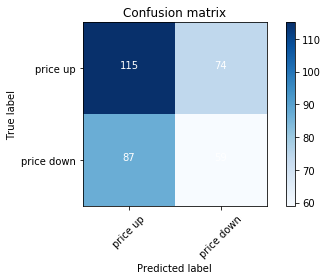

In [136]:
plot_confusion_matrix(confusion_matrix(test['target'], results), classes=['price up', 'price down'])
plt.savefig('download.png')

In [130]:
roc_auc_score(test['target'], results)

0.5062875987533522

In [131]:
matthews_corrcoef(test['target'], results)

0.01274443655480002

In [132]:
accuracy_score(test['target'], results)

0.5194029850746269

In [139]:
train[['Date', 'target', 'words']].iloc[4:].reset_index(drop=True)

,Date,target,words
0,2013-02-25,1,Not sure. Although I would consider myself a p...
1,2013-02-26,0,"Lol, 10 observation regression, such power! [d..."
2,2013-02-27,0,[deleted] I lost in the western michigan compe...
3,2013-02-28,1,I think discussion around derivatives misses t...
4,2013-03-01,0,"&gt; Unfortunately, the biggest problem that b..."
5,2013-03-04,0,They may have it hedged.\n\nThink of it this w...
6,2013-03-05,0,Actually the guys that he has been putting in ...
7,2013-03-06,0,No worries! We're both just trying to help and...
8,2013-03-07,0,I'm seeing some irrational exhuberance. Im no...
9,2013-03-08,0,Thanks for clarifying. I wholeheartedly agree....
